In [43]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
# from skimage import io, transform
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# 範例數據集規則如下

image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y <br/>
0805personali01.jpg,27,83,27,98, ... 84,134 <br/>
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312 <br/>


In [2]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].to_numpy()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks:\n {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks:
 [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


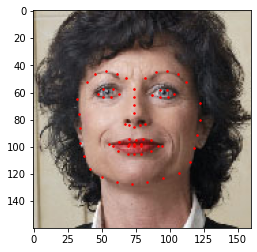

In [29]:
def show_landmarks(image, landmarks):
    '''
    顯示帶有landmarks的圖
    '''
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)


plt.figure()
img_bgr = cv2.imread(os.path.join('data/faces/', img_name))
img_rgb = img_bgr[:,:,::-1]
show_landmarks(img_rgb, landmarks)
plt.show()

# Dataset

``torch.utils.data.Dataset``是表示數據集的抽象類別，因此自定義數據集應繼承 Dataset 並覆寫以下方法 
* ``__len__`` 實現 ``len(dataset)`` 回傳數據集size
* ``__getitem__`` 透過index來取得物件，例如 dataset[i] 中的(i)

創建數據集類別
* 在 ``__init__`` 中讀取csv的文件內容
* 在 ``__getitem__`` 中讀取圖片

這樣的做法為了節省記憶體，只有在需要用到圖片的時候才讀取它而不是一開始就把圖片全部存進記憶體裡


In [30]:
class FaceLandmarksDataset(Dataset):
    '''
    臉部標記數據集
    '''

    def __init__(self, csv_file, root_dir, transform=None):
        """
        csv_file（string）：帶有landmarks資訊的csv文件路徑
        root_dir（string）：圖片目錄
        transform（callable， optional）：圖片樣本轉換用的函數
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        img_bgr = cv2.imread(img_name)
        image = img_bgr[:,:,::-1]

        landmarks = self.landmarks_frame.iloc[idx, 1:].to_numpy()
        # landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (324, 215, 3) (68, 2)


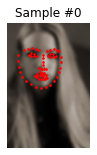

1 (500, 333, 3) (68, 2)


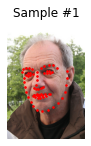

2 (250, 258, 3) (68, 2)


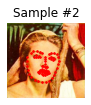

3 (434, 290, 3) (68, 2)


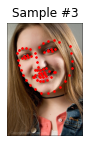

In [31]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', root_dir='data/faces/')
                    
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

# 資料轉換 Transform

上面的例子我們會發現圖片並不是同樣的尺寸，絕大多數神經網絡都假定圖片的尺寸相同，因此需要做一些預處理

創建三個轉換: 
* Rescale：縮放圖片 
* RandomCrop：對圖片進行隨機裁剪，這是一種數據增強(Data Augmentation)操作 
* ToTensor：把numpy格式圖片轉為torch格式圖片 (需要交換坐標軸)

In [ ]:
class Rescale(object):
    '''
    將圖片縮放到指定大小
    '''

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


# 組合轉換

把圖像的短邊調整為256，然後隨機裁剪(randomcrop)為224大小的正方形

可以調用一個簡單的類 ``torchvision.transforms.Compose`` 來實現這個操作

In [2]:
data_transform = transforms.Compose([
    Rescale(256),
    transforms.RandomSizedCrop(224), 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor()
    ])

transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=data_transform)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break


NameError: name 'transforms' is not defined

# Dataloader

``torch.utils.data.DataLoader`` 是一個提供上述所有這些功能的迭代器

值得關注的參數是collat​​e_fn, 可以通過它來決定如何對數據進行批處理，但是絕大多數情況下默認值就能運行良好

In [ ]:
dataloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=4, shuffle=True)

In [ ]:
next(iter(dataloader))